In [2]:
!pip install --upgrade selenium

## 크롤링, 전처리, clustering 코드입니다 ##
## Git에 크롤링해서 얻은 data 업로드하였습니다##
## 전처리 및 clustering 하는 코드는 crawling 코드 밑에 있습니다 ##

   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   - -------------------------------------- 0.4/10.0 MB 8.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/10.0 MB 9.5 MB/s eta 0:00:01
   ----- ---------------------------------- 1.4/10.0 MB 9.9 MB/s eta 0:00:01
   ------- -------------------------------- 1.9/10.0 MB 10.1 MB/s eta 0:00:01
   --------- ------------------------------ 2.4/10.0 MB 10.2 MB/s eta 0:00:01
   ----------- ---------------------------- 2.9/10.0 MB 10.3 MB/s eta 0:00:01
   ------------- -------------------------- 3.4/10.0 MB 10.4 MB/s eta 0:00:01
   --------------- ------------------------ 3.9/10.0 MB 10.5 MB/s eta 0:00:01
   ----------------- ---------------------- 4.4/10.0 MB 10.4 MB/s eta 0:00:01
   -------------------- ------------------- 5.1/10.0 MB 10.5 MB/s eta 0:00:01
   ---------------------- ----------------- 5.6/10.0 MB 10.5 MB/s eta 0:00:01
   ------------------------- -------------- 6.3/10.0 MB 10.5 MB/s eta 0:00:

In [8]:
from selenium import webdriver
import time
from openpyxl import Workbook
import pandas as pd
from selenium.common import TimeoutException
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup

import warnings

from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait

warnings.filterwarnings('ignore')

In [9]:
from selenium import webdriver

options = webdriver.ChromeOptions()
# options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Use 'options' instead of 'chrome_options'
driver = webdriver.Chrome(options=options)

In [10]:
wb = Workbook(write_only=True)
ws = wb.create_sheet()

driver.get("https://www.youtube.com/watch?v=uV2thF-NFjk")
driver.implicitly_wait(3)

time.sleep(1.5)

driver.execute_script("window.scrollTo(0, 800)")
time.sleep(3)

In [14]:
last_height = driver.execute_script("return document.documentElement.scrollHeight")

while True:
    driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
    time.sleep(1.5)

    new_height = driver.execute_script("return document.documentElement.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

time.sleep(1.5)

In [16]:
 # Youtube-Premium pop up ignore 이거 수정하기
try:
    driver.find_element_by_css_selector("#dismiss-button > a").click()
except:
    pass

In [17]:
html_source = driver.page_source
soup = BeautifulSoup(html_source, 'html.parser')

id_list = soup.select("div#header-author > h3 > #author-text")

comment_list = soup.select("yt-formatted-string#content-text")

print(len(id_list), len(comment_list))

id_final = []
comment_final = []

for i in range(len(comment_list)):
    temp_id = id_list[i].text
    temp_id = temp_id.replace('\n', '')
    temp_id = temp_id.replace('\t', '')
    temp_id = temp_id.replace('    ', '')
    id_final.append(temp_id)  # 댓글 작성자

    temp_comment = comment_list[i].text
    temp_comment = temp_comment.replace('\n', '')
    temp_comment = temp_comment.replace('\t', '')
    temp_comment = temp_comment.replace('    ', '')
    comment_final.append(temp_comment)  # 댓글 내용

1231 1231


In [18]:
pd_data = {"아이디": id_final, "댓글 내용": comment_final}
youtube_pd = pd.DataFrame(pd_data)

youtube_pd.to_excel('result.xlsx')
youtube_pd.head()

,아이디,댓글 내용
0,@user-wb5jt9xn5m,여름 특집으로 공포게임만 기다리고 있으면 개추 ㅋㅋㅋㅋㅋ
1,@real_ordinary_girl,"4개월 구독자 진정한 랄뚜기 두치좌 ""지랄말고 가쇼"" 역대급 명언이었다ㅋㅋㅋ"
2,@user-yn9jg8qe1p,떨어질지 모르며 자신만만하게 등반하다가 급하강을 겪은후로 타락해 판별력을 잃는 모습...
3,@dkcncikekdx,김찬호는 그냥 방송의 신이다 2시간 20분동안 웃다가 눈물까지 나오네 ㅋㅋㅋㅋㅋㅋㅋ...
4,@Beemil2,랄로는 ㄹㅇ 롤이 억제기다.. 진짜 방송의 신이네


In [19]:
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import random
import os


def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


set_seed(42)

In [20]:
# 데이터 불러오기
youtube_comments = pd.read_excel('result.xlsx')


# 자음만으로 이루어진 단어, 숫자 및 특수 기호를 제거하는 함수

def remove_special_characters(text):
    # 특수기호 제거 후 아무것도 넣지 않음
    text = re.sub(r'[^가-힣0-9\s]', '', text)

    text = re.sub(r'[0-9]', '', text)

    return text  # 공백 없이 결합


def remove_numbers(text):
    # 숫자 제거 후 아무것도 넣지 않음
    text = re.sub(r'[0-9]', '', text)

    # 형태소 분석
    return text  # 공백 없이 결합


# 댓글 데이터에 함수 적용
youtube_comments['댓글 내용'] = youtube_comments['댓글 내용'].apply(remove_special_characters)

youtube_comments.dropna(subset=['댓글 내용'], inplace=True)
youtube_comments = youtube_comments[youtube_comments['댓글 내용'].str.strip().astype(bool)]

youtube_comments.to_excel('preprocessed_comments.xlsx', index=False)

In [22]:
# TF-IDF Vectorizer 생성 및 변환
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, ngram_range=(1, 2), max_features=60, stop_words='english')
X = tfidf_vectorizer.fit_transform(youtube_comments['댓글 내용'])

# Normalize
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X)

# Cosine Similarity
cosine_sim_matrix = cosine_similarity(X_normalized)

In [24]:
# KMeans 클러스터링
kmeans = KMeans(n_clusters=25, init='k-means++', max_iter=10000, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(X_normalized)

# 클러스터 결과 추가
youtube_comments['cluster'] = kmeans_clusters

# Create 'kMeans' directory if it does not exist
directory = 'kMeans_result'
if not os.path.exists(directory):
    os.makedirs(directory)

# 클러스터별로 파일로 저장
for i in range(25):  # The number of clusters is set to 25, so here we repeat until 25
    cluster_data = youtube_comments[youtube_comments['cluster'] == i]
    # Include the 'kMeans' directory in the file path
    file_path = os.path.join(directory, f'kMeans_cluster_{i}_comments.csv')
    cluster_data.to_csv(file_path, index=False)
    print(f'kMeans_Cluster {i} saved to {file_path}')

# 실루엣 스코어 계산
silhouette_avg = silhouette_score(X_normalized, kmeans_clusters)
print("실루엣 스코어:", silhouette_avg)
# X_normalized가 희소 행렬인 경우 밀집 행렬로 변환
X_dense = X_normalized.toarray()
# 데이비스-볼딘 지수 계산
davies_bouldin = davies_bouldin_score(X_dense, kmeans_clusters)
print("데이비스-볼딘 지수:", davies_bouldin)

# 칼린스키-하라바즈 지수 계산
calinski_harabasz = calinski_harabasz_score(X_dense, kmeans_clusters)
print("칼린스키-하라바즈 지수:", calinski_harabasz)

kMeans_Cluster 0 saved to kMeans_result\kMeans_cluster_0_comments.csv
kMeans_Cluster 1 saved to kMeans_result\kMeans_cluster_1_comments.csv
kMeans_Cluster 2 saved to kMeans_result\kMeans_cluster_2_comments.csv
kMeans_Cluster 3 saved to kMeans_result\kMeans_cluster_3_comments.csv
kMeans_Cluster 4 saved to kMeans_result\kMeans_cluster_4_comments.csv
kMeans_Cluster 5 saved to kMeans_result\kMeans_cluster_5_comments.csv
kMeans_Cluster 6 saved to kMeans_result\kMeans_cluster_6_comments.csv
kMeans_Cluster 7 saved to kMeans_result\kMeans_cluster_7_comments.csv
kMeans_Cluster 8 saved to kMeans_result\kMeans_cluster_8_comments.csv
kMeans_Cluster 9 saved to kMeans_result\kMeans_cluster_9_comments.csv
kMeans_Cluster 10 saved to kMeans_result\kMeans_cluster_10_comments.csv
kMeans_Cluster 11 saved to kMeans_result\kMeans_cluster_11_comments.csv
kMeans_Cluster 12 saved to kMeans_result\kMeans_cluster_12_comments.csv
kMeans_Cluster 13 saved to kMeans_result\kMeans_cluster_13_comments.csv
kMeans_Clust

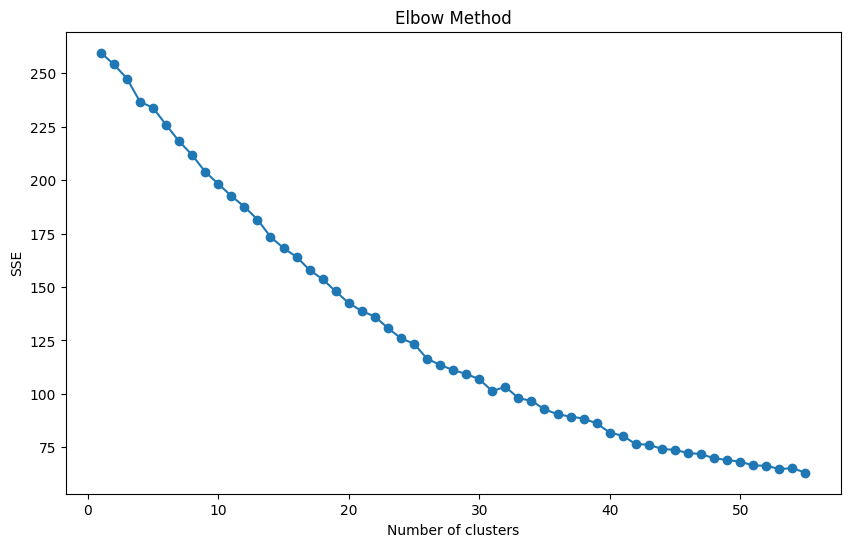

In [25]:
# SSE 값들을 저장할 리스트
sse = []

# 다양한 클러스터 수에 대해 KMeans 클러스터링 실행
for k in range(15, 70):  # 클러스터 수를 1부터 10까지 시도
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=2000, random_state=42, n_init=10)
    kmeans.fit(X_normalized)
    sse.append(kmeans.inertia_)

# Elbow 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sse) + 1), sse, marker='o')  # sse 리스트의 길이에 맞게 x 축 범위 조정
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [26]:
# 계층적 클러스터링
agglo = AgglomerativeClustering(n_clusters=25)
Agg_clusters = agglo.fit_predict(cosine_sim_matrix)

# 클러스터 결과 추가
youtube_comments['cluster'] = Agg_clusters

# Create 'kMeans' directory if it does not exist
directory = 'Agglo_result'
if not os.path.exists(directory):
    os.makedirs(directory)

# 클러스터별로 파일로 저장
for i in range(25):  # The number of clusters is set to 25, so here we repeat until 25
    cluster_data = youtube_comments[youtube_comments['cluster'] == i]
    # Include the 'kMeans' directory in the file path
    file_path = os.path.join(directory, f'hierarchical_cluster_{i}_comments.csv')
    cluster_data.to_csv(file_path, index=False)
    print(f'Hierarchical_cluster {i} saved to {file_path}')

# 실루엣 스코어 계산
silhouette_avg = silhouette_score(X, Agg_clusters)
print("실루엣 스코어:", silhouette_avg)

Hierarchical_cluster 0 saved to Agglo_result\hierarchical_cluster_0_comments.csv
Hierarchical_cluster 1 saved to Agglo_result\hierarchical_cluster_1_comments.csv
Hierarchical_cluster 2 saved to Agglo_result\hierarchical_cluster_2_comments.csv
Hierarchical_cluster 3 saved to Agglo_result\hierarchical_cluster_3_comments.csv
Hierarchical_cluster 4 saved to Agglo_result\hierarchical_cluster_4_comments.csv
Hierarchical_cluster 5 saved to Agglo_result\hierarchical_cluster_5_comments.csv
Hierarchical_cluster 6 saved to Agglo_result\hierarchical_cluster_6_comments.csv
Hierarchical_cluster 7 saved to Agglo_result\hierarchical_cluster_7_comments.csv
Hierarchical_cluster 8 saved to Agglo_result\hierarchical_cluster_8_comments.csv
Hierarchical_cluster 9 saved to Agglo_result\hierarchical_cluster_9_comments.csv
Hierarchical_cluster 10 saved to Agglo_result\hierarchical_cluster_10_comments.csv
Hierarchical_cluster 11 saved to Agglo_result\hierarchical_cluster_11_comments.csv
Hierarchical_cluster 12 

In [27]:
# DBSCAN 클러스터링
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(cosine_sim_matrix)

# 클러스터 결과 추가
youtube_comments['cluster'] = dbscan_clusters

# Create 'kMeans' directory if it does not exist
directory = 'DBscan_result'
if not os.path.exists(directory):
    os.makedirs(directory)

# 클러스터별로 파일로 저장
for i in range(25):  # The number of clusters is set to 25, so here we repeat until 25
    cluster_data = youtube_comments[youtube_comments['cluster'] == i]
    # Include the 'kMeans' directory in the file path
    file_path = os.path.join(directory, f'DBscan_cluster_{i}_comments.csv')
    cluster_data.to_csv(file_path, index=False)
    print(f'DBscan_cluster {i} saved to {file_path}')

silhouette_avg = silhouette_score(X, dbscan_clusters)
print("실루엣 스코어:", silhouette_avg)

DBscan_cluster 0 saved to DBscan_result\DBscan_cluster_0_comments.csv
DBscan_cluster 1 saved to DBscan_result\DBscan_cluster_1_comments.csv
DBscan_cluster 2 saved to DBscan_result\DBscan_cluster_2_comments.csv
DBscan_cluster 3 saved to DBscan_result\DBscan_cluster_3_comments.csv
DBscan_cluster 4 saved to DBscan_result\DBscan_cluster_4_comments.csv
DBscan_cluster 5 saved to DBscan_result\DBscan_cluster_5_comments.csv
DBscan_cluster 6 saved to DBscan_result\DBscan_cluster_6_comments.csv
DBscan_cluster 7 saved to DBscan_result\DBscan_cluster_7_comments.csv
DBscan_cluster 8 saved to DBscan_result\DBscan_cluster_8_comments.csv
DBscan_cluster 9 saved to DBscan_result\DBscan_cluster_9_comments.csv
DBscan_cluster 10 saved to DBscan_result\DBscan_cluster_10_comments.csv
DBscan_cluster 11 saved to DBscan_result\DBscan_cluster_11_comments.csv
DBscan_cluster 12 saved to DBscan_result\DBscan_cluster_12_comments.csv
DBscan_cluster 13 saved to DBscan_result\DBscan_cluster_13_comments.csv
DBscan_clust

In [28]:
# PCA로 차원 축소
pca = PCA(n_components=49)
X_pca = pca.fit_transform(X_normalized.toarray())  # PCA는 dense matrix를 필요로 합니다.

# KMeans++ 클러스터링
kmeans = KMeans(n_clusters=25, init='k-means++', max_iter=10000, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# 클러스터 결과 추가
youtube_comments['cluster'] = clusters

import os

# Create 'PCA_result' directory if it does not exist
directory = 'PCA_result'
if not os.path.exists(directory):
    os.makedirs(directory)

for i in range(25):  # The number of clusters is set to 25
    cluster_data = youtube_comments[youtube_comments['cluster'] == i]
    # Save cluster data in the 'PCA_result' directory
    file_path = os.path.join(directory, f'cluster_{i}_PCA_comments.csv')
    cluster_data.to_csv(file_path, index=False)
    print(f'Cluster {i} saved to {file_path}')

# 실루엣 스코어 계산
silhouette_avg = silhouette_score(X_normalized, clusters)
print("실루엣 스코어:", silhouette_avg)
# X_normalized가 희소 행렬인 경우 밀집 행렬로 변환
X_dense = X_normalized.toarray()
# 데이비스-볼딘 지수 계산
davies_bouldin = davies_bouldin_score(X_dense, clusters)
print("데이비스-볼딘 지수:", davies_bouldin)

# 칼린스키-하라바즈 지수 계산
calinski_harabasz = calinski_harabasz_score(X_dense, clusters)
print("칼린스키-하라바즈 지수:", calinski_harabasz)

Cluster 0 saved to PCA_result\cluster_0_PCA_comments.csv
Cluster 1 saved to PCA_result\cluster_1_PCA_comments.csv
Cluster 2 saved to PCA_result\cluster_2_PCA_comments.csv
Cluster 3 saved to PCA_result\cluster_3_PCA_comments.csv
Cluster 4 saved to PCA_result\cluster_4_PCA_comments.csv
Cluster 5 saved to PCA_result\cluster_5_PCA_comments.csv
Cluster 6 saved to PCA_result\cluster_6_PCA_comments.csv
Cluster 7 saved to PCA_result\cluster_7_PCA_comments.csv
Cluster 8 saved to PCA_result\cluster_8_PCA_comments.csv
Cluster 9 saved to PCA_result\cluster_9_PCA_comments.csv
Cluster 10 saved to PCA_result\cluster_10_PCA_comments.csv
Cluster 11 saved to PCA_result\cluster_11_PCA_comments.csv
Cluster 12 saved to PCA_result\cluster_12_PCA_comments.csv
Cluster 13 saved to PCA_result\cluster_13_PCA_comments.csv
Cluster 14 saved to PCA_result\cluster_14_PCA_comments.csv
Cluster 15 saved to PCA_result\cluster_15_PCA_comments.csv
Cluster 16 saved to PCA_result\cluster_16_PCA_comments.csv
Cluster 17 saved 

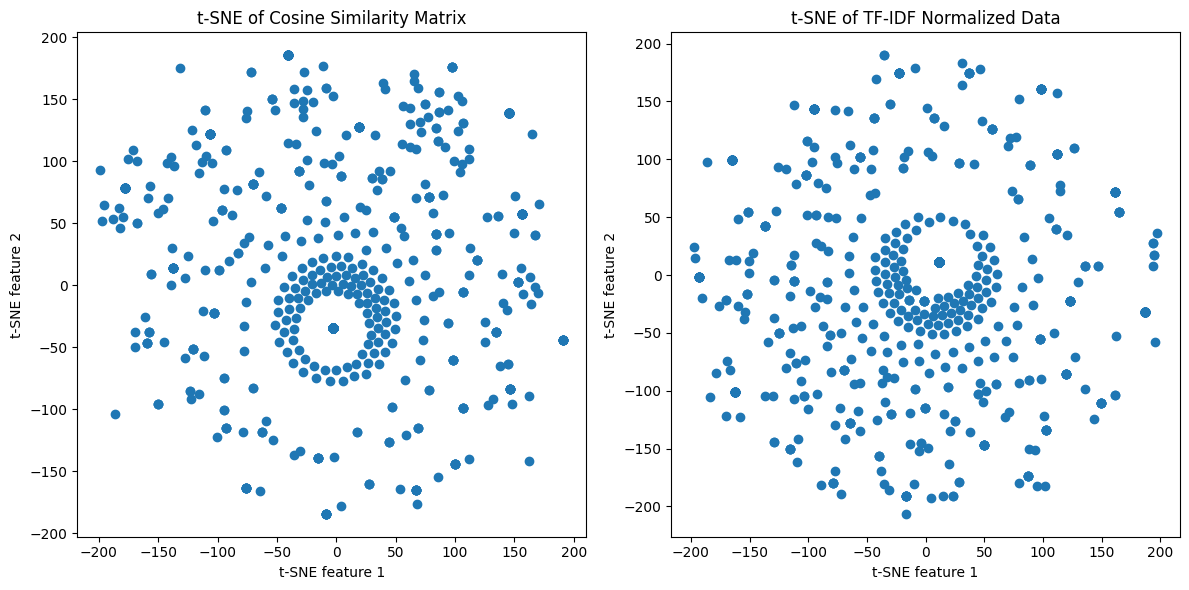

In [29]:
# t-SNE 인스턴스 생성
tsne = TSNE(n_components=2, random_state=42)

# Cosine Similarity 행렬에 대한 t-SNE
X_tsne_cosine = tsne.fit_transform(cosine_sim_matrix)

# TF-IDF Normalized 데이터에 대한 t-SNE
X_tsne_tfidf = tsne.fit_transform(X_normalized.toarray())

# Cosine Similarity 행렬에 대한 t-SNE 결과 그리기
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_tsne_cosine[:, 0], X_tsne_cosine[:, 1])
plt.title('t-SNE of Cosine Similarity Matrix')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')

# TF-IDF Normalized 데이터에 대한 t-SNE 결과 그리기
plt.subplot(1, 2, 2)
plt.scatter(X_tsne_tfidf[:, 0], X_tsne_tfidf[:, 1])
plt.title('t-SNE of TF-IDF Normalized Data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')

plt.tight_layout()
plt.show()

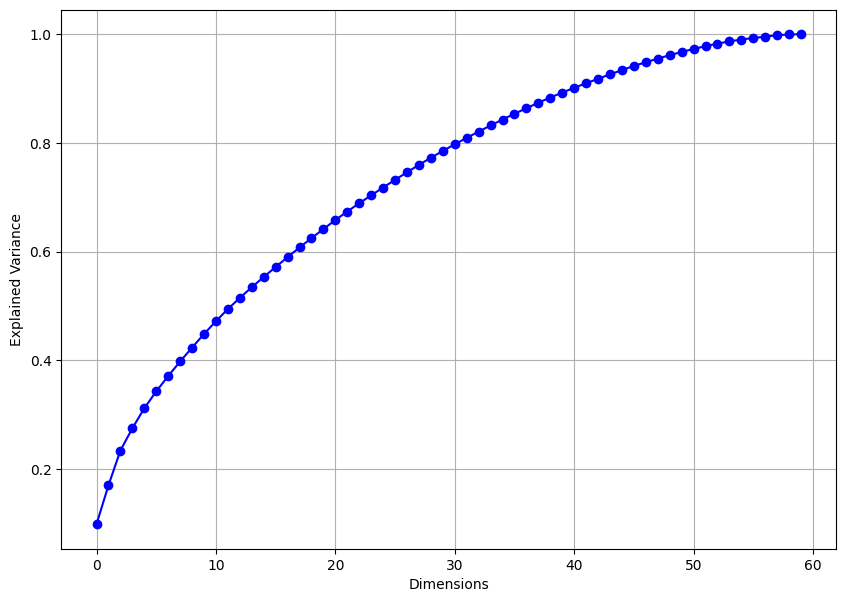

누적 설명 분산이 95% 이상인 최소 차원 수: 48


In [30]:
# PCA 인스턴스 생성
pca = PCA()

# Normalize된 데이터에 PCA 적용
pca.fit(X_normalized.toarray())

# 설명된 분산의 누적합 계산
cumsum = np.cumsum(pca.explained_variance_ratio_)

# 설명된 분산의 누적합 그래프 그리기
plt.figure(figsize=(10,7))
plt.plot(cumsum, 'bo-')
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.grid(True)
plt.show()

# 누적 설명 분산이 95% 이상인 최소 차원 수 찾기
dimension = np.argmax(cumsum >= 0.95) + 1  # 인덱스는 0부터 시작하므로 1을 더함

print("누적 설명 분산이 95% 이상인 최소 차원 수:", dimension)